**About** : This notebook is used to train models.

Ideas :
- https://www.kaggle.com/c/open-images-2019-instance-segmentation/discussion/110983

- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95247#latest-567841
- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95233#latest-551075
- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95234#latest-555537

- https://www.kaggle.com/c/airbus-ship-detection/discussion/71595#latest-457550
- https://www.kaggle.com/c/airbus-ship-detection/discussion/71667#latest-558876

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/home/theo/Documents/sartorius/src


## Initialization

### Imports

In [3]:
import os
import ast
import sys
import cv2
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
warnings.simplefilter("ignore", UserWarning)

In [4]:
from params import *

from utils.plots import *
from utils.metrics import iou_map
from utils.rle import rles_to_mask_fix
from utils.logger import prepare_log_folder, create_logger, save_config

from data.preparation import prepare_data
from data.dataset import SartoriusDataset
from data.transforms import define_pipelines

from training.main import k_fold
from inference.post_process import *

In [5]:
import mmdet
import mmdet.models
from mmcv import Config

from mmcv.utils import build_from_cfg
from mmdet.datasets.builder import PIPELINES
from mmdet.datasets.pipelines import Compose

## Data

In [6]:
df = prepare_data()

In [7]:
pipelines = define_pipelines("data/config_aug.py")

In [8]:
# dataset = SartoriusDataset(df, pipelines['test_viz'], precompute_masks=False)
dataset = SartoriusDataset(df, pipelines['val_viz'], precompute_masks=False)

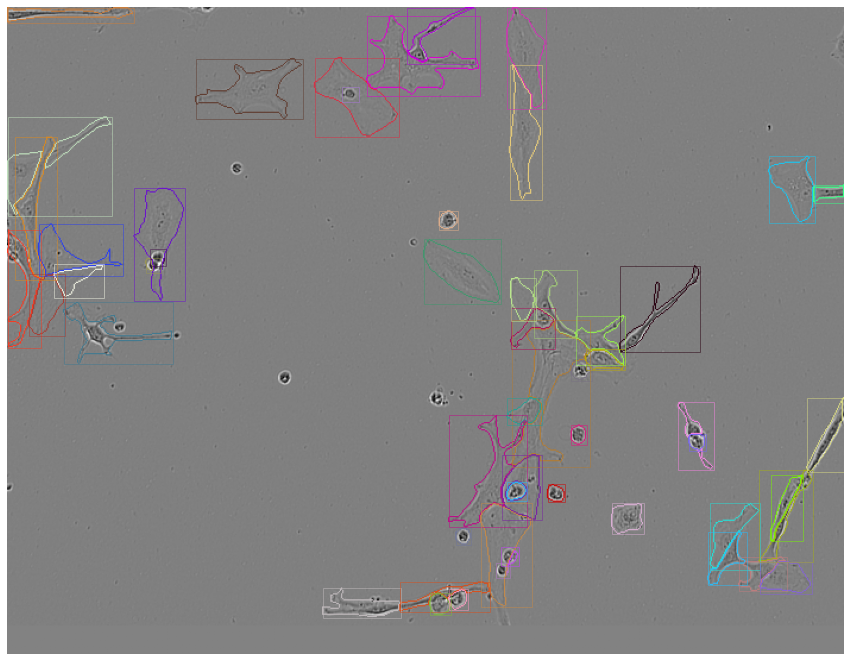

In [9]:
idx = 101

data = dataset[idx]

img = data['img']
boxes = data['gt_bboxes']

plt.figure(figsize=(15, 15))
plot_sample(img, data['gt_masks'], boxes, plotly=False)
plt.axis(False)
plt.show()

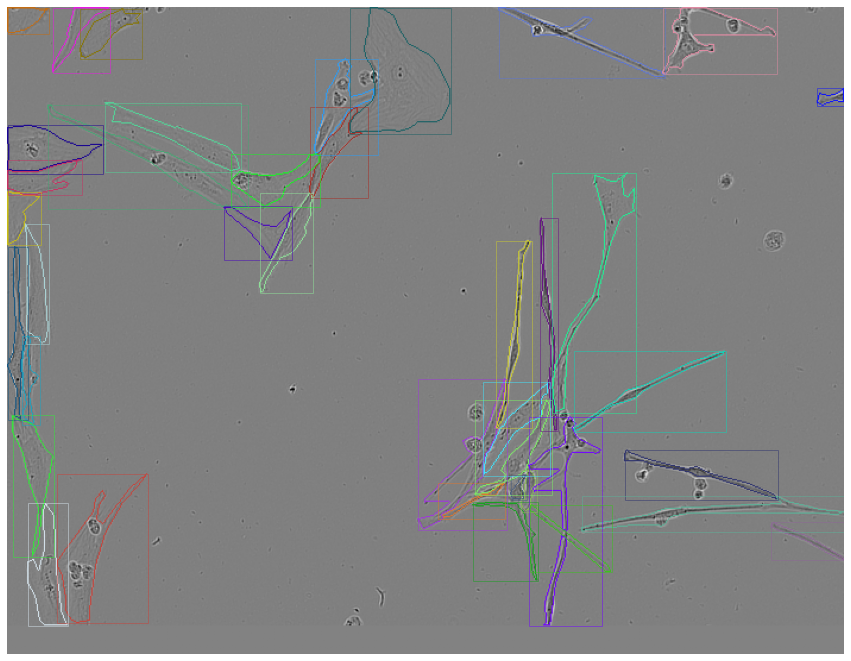

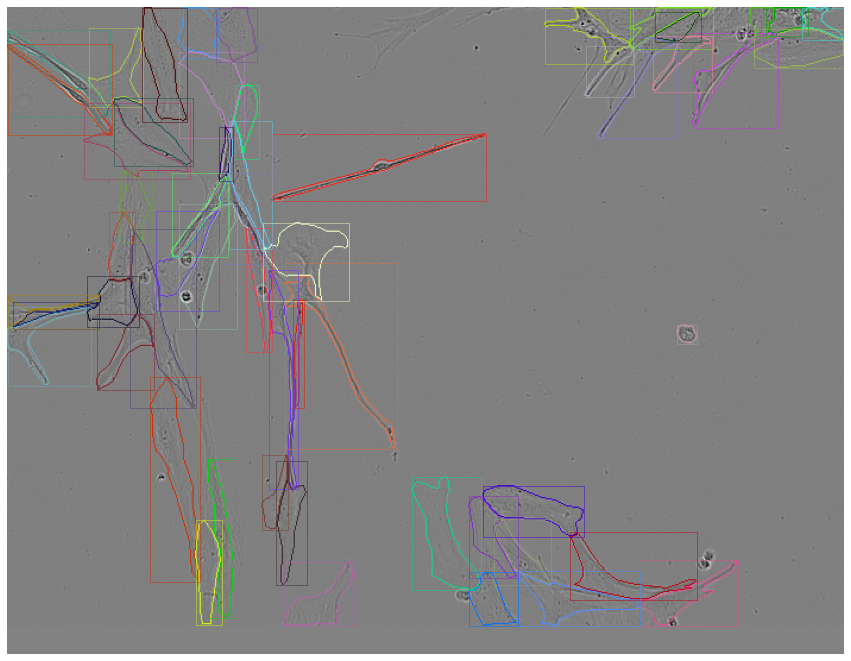

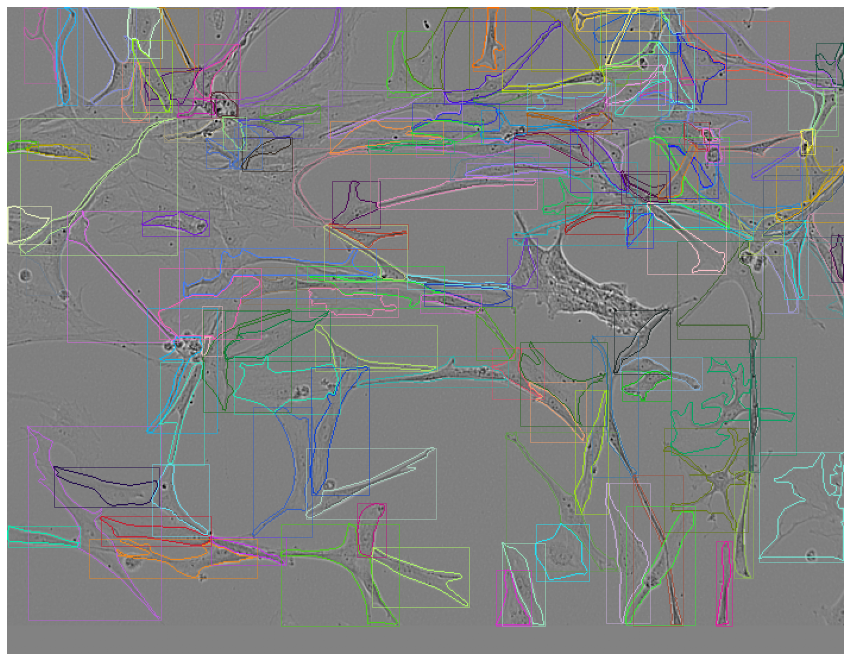

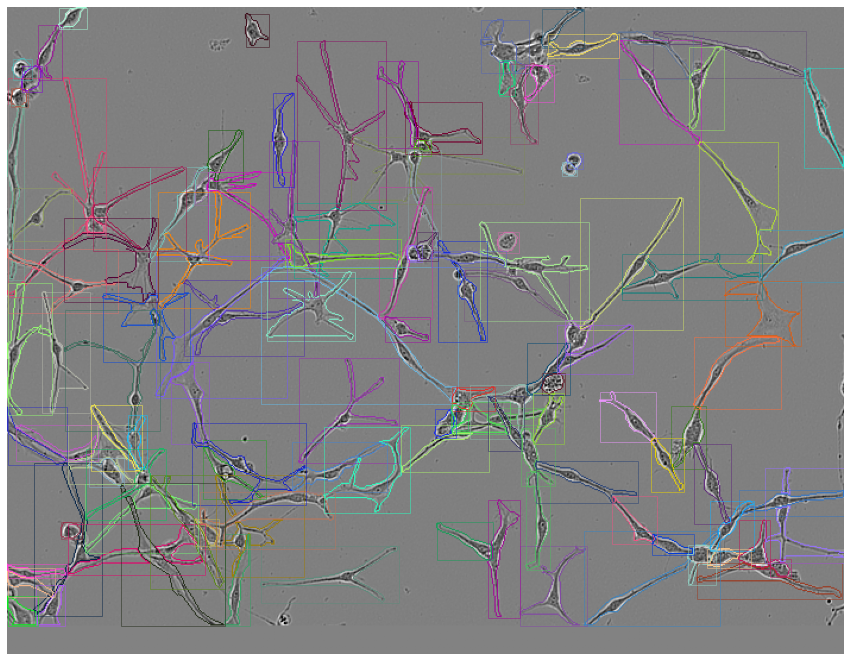

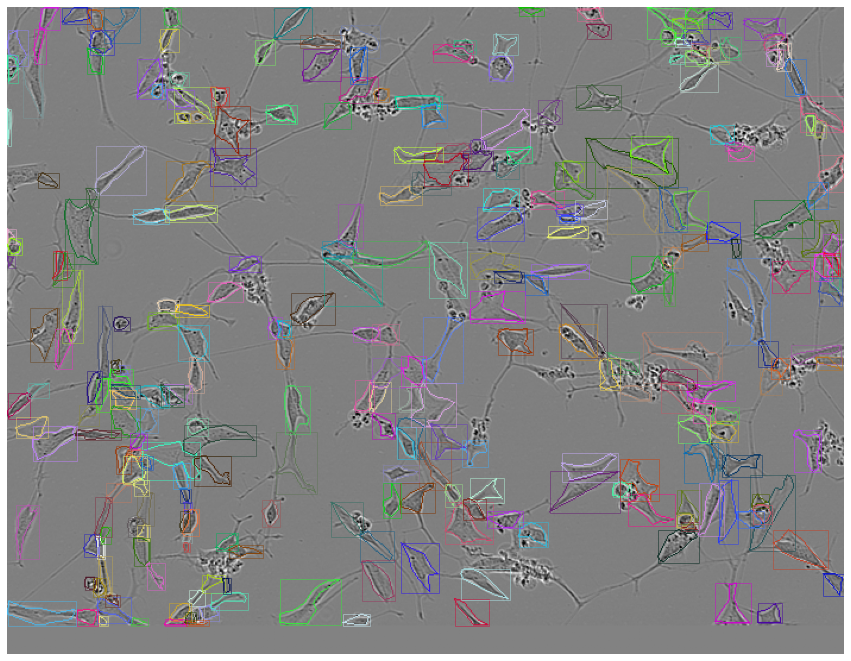

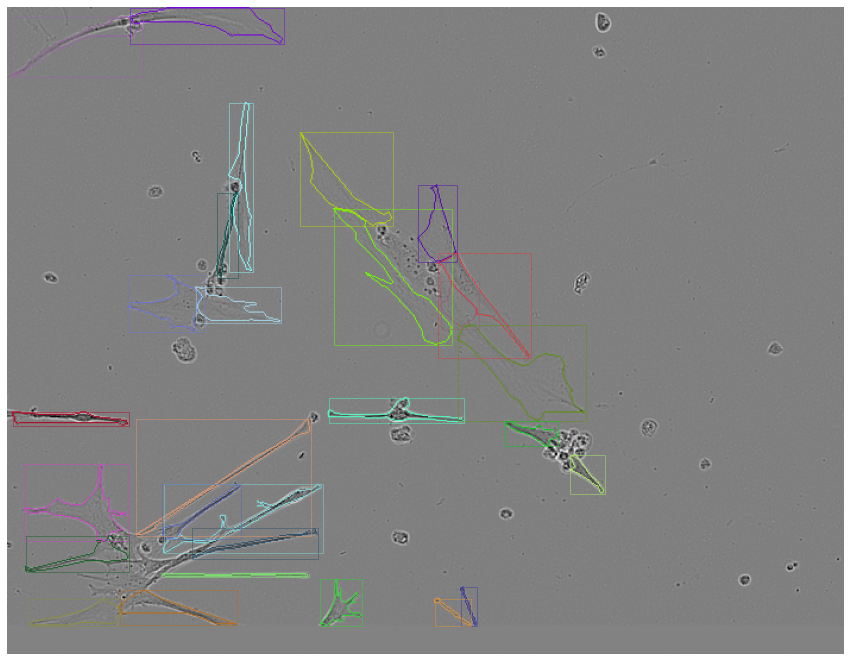

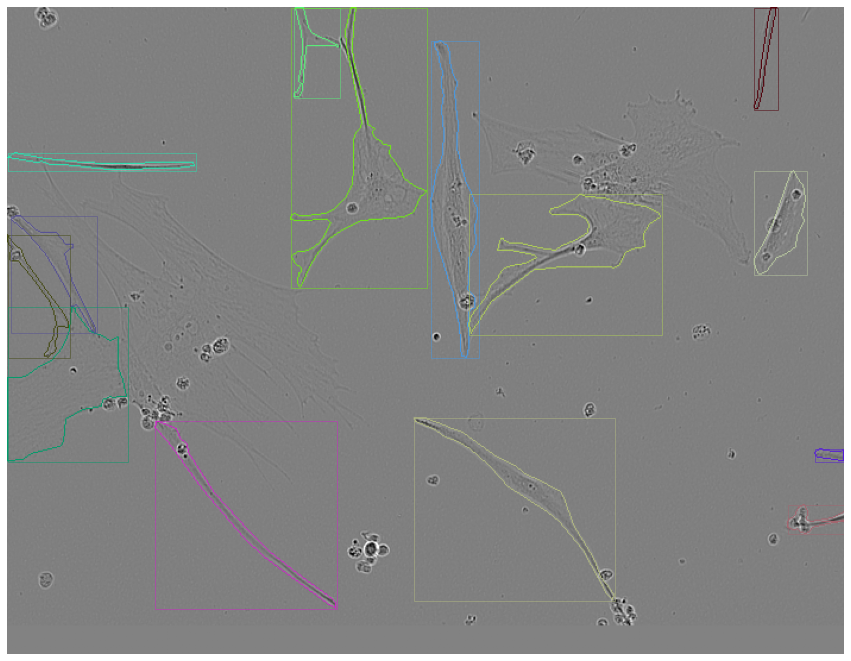

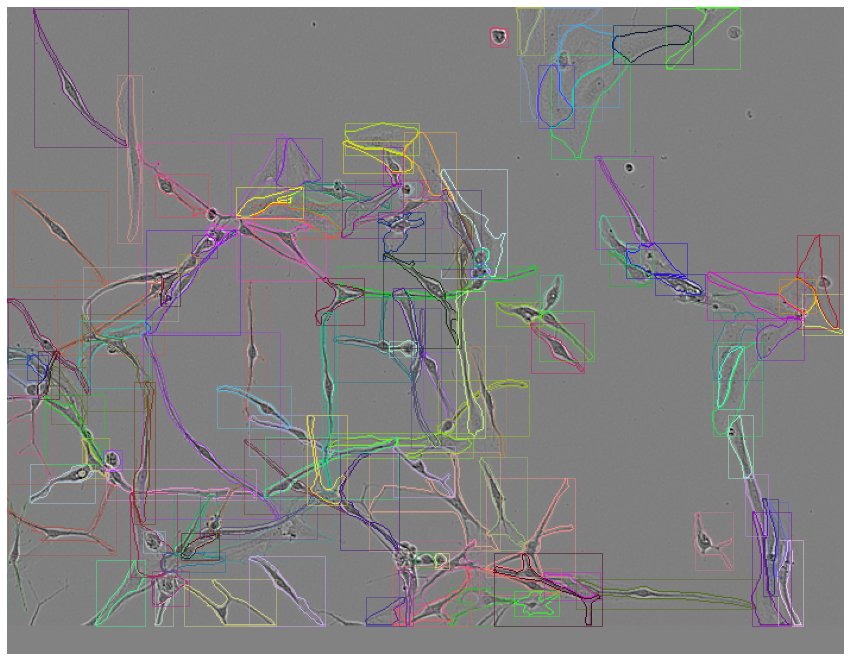

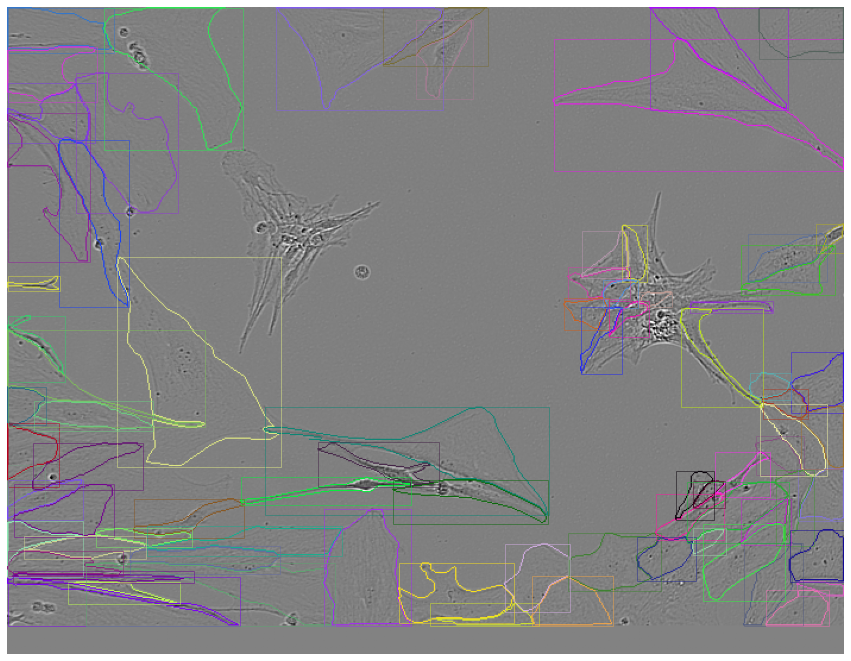

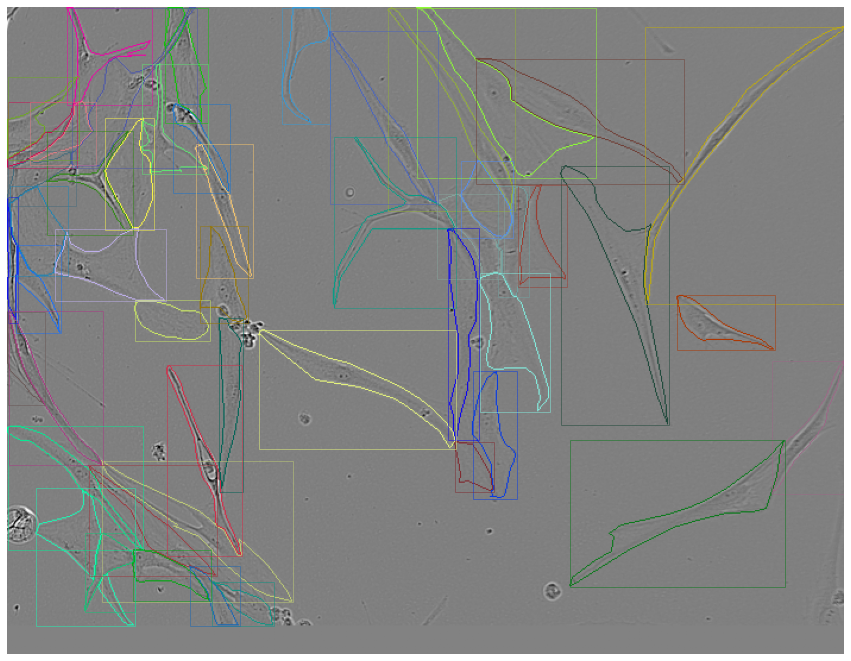

In [29]:
sizes_, ratios_ = [], []
for i in tqdm(range(len(dataset))):
    data = dataset[i]
#     img = data['img']
    boxes = data['gt_bboxes'].astype(float)

    sizes = np.max([boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1]], 0)
    ratios = (boxes[:, 2] - boxes[:, 0]) / (boxes[:, 3] - boxes[:, 1])
    ratios = np.max([ratios, 1 / ratios], 0)
    
    if np.max(ratios) > 10:
#     if np.max(sizes) > 256:
        plt.figure(figsize=(15, 15))
        plot_sample(data['img'], data['gt_masks'], boxes, plotly=False)
        plt.axis(False)
        plt.show()
        
    
    sizes_.append(sizes)
    ratios_.append(ratios)

In [25]:
sizes = np.concatenate(sizes_)

In [26]:
sizes[sizes > 256]

array([268., 274., 265., 268., 332., 302., 322., 342., 345., 267., 262.])

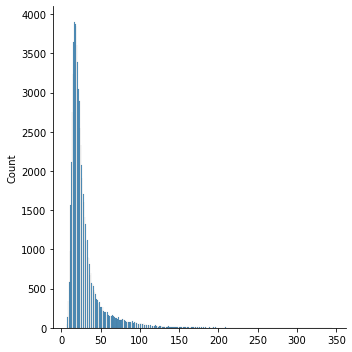

In [21]:
sns.displot(np.concatenate(sizes_))

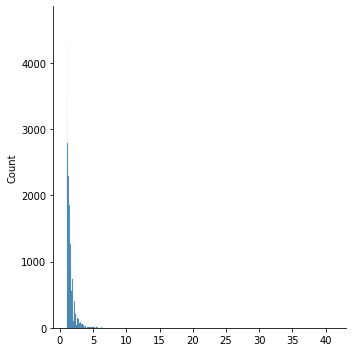

In [27]:
sns.displot(np.concatenate(ratios_))

In [ ]:
dataset = SartoriusDataset(df, pipelines['train_viz'], precompute_masks=False)

In [ ]:
for _ in range(1):
    plt.figure(figsize=(15, 15))
    
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        idx = np.random.choice(len(dataset))
#         idx = 581

        data = dataset[idx]
        plot_sample(data['img'], data['gt_masks'], data['gt_bboxes'], plotly=False)
#         print(data['img'].shape)

        plt.axis(False)
    plt.show()

## Model

In [ ]:
from data.loader import define_loaders
from training.optim import define_optimizer

from model_zoo.models import define_model

In [ ]:
# model = define_model("model_zoo/config.py", reduce_stride=True)

## Training

In [ ]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    first_epoch_eval = 10
    compute_val_loss = False
    verbose_eval = 10

    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # Images
    use_tta = False  # TODO
    data_config = "data/config.py"

    # k-fold
    k = 5
    random_state = 0
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    reduce_stride = False
    model_config = "model_zoo/config_stride.py" if reduce_stride else "model_zoo/config.py"
    name = "maskrcnn"
    pretrained_folder = LOG_PATH + "2021-10-30/0/" if reduce_stride else None

    # Training
    optimizer = "Adam"
    weight_decay = 0  # 0.0001
    batch_size = 6 if reduce_stride else 12
    val_bs = batch_size

    epochs = 50

    lr = 1e-3 if reduce_stride else 2e-3
    warmup_prop = 0.1 if reduce_stride else 0.05

    use_fp16 = False  # TODO

In [ ]:
DEBUG = True
log_folder = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    save_config(Config, log_folder + "config.json")
    create_logger(directory=log_folder, name="logs.txt")

results = k_fold(Config, log_folder=log_folder)